In [ ]:
!pip install mapclassify -q
!pip install skimpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 6.17.1
    Uninstalling ipykernel-6.17.1:
      Successfully uninstalled ipykernel-6.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==6.17.1, but you have ipykernel 6.29.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatibl

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import folium
import mapclassify
from skimpy import clean_columns
import requests
import re

## LA County SVI & Census Tracts

In [ ]:
# read in data
url = 'https://raw.githubusercontent.com/giovani-gutierrez/TDA_CalFire_Project/refs/heads/main/Data/svi_tracts.json'
data = requests.get(url)
svi = gpd.GeoDataFrame.from_features(data.json())

# preview data
svi.head()

,geometry,tract,e_totpop,m_totpop,e_hu,m_hu,e_hh,m_hh,e_pov_150,m_pov_150,...,ep_asian,mp_asian,ep_aian,mp_aian,ep_nhpi,mp_nhpi,ep_twomore,mp_twomore,ep_otherrace,mp_otherrace
0,"POLYGON ((-118.29793 34.26323, -118.30082 34.2...",1011.10,4014.0,473.0,1652.0,97.0,1551.0,130.0,586.0,214.0,...,9.7,3.8,0.2,0.4,0.0,1.0,4.2,2.8,0.2,0.3
1,"POLYGON ((-118.27743 34.25991, -118.27743 34.2...",1011.22,4164.0,822.0,1427.0,170.0,1383.0,160.0,404.0,236.0,...,14.0,5.2,0.0,1.0,0.0,1.0,6.0,3.1,0.3,0.5
2,"POLYGON ((-118.27818 34.25577, -118.27887 34.2...",1012.20,3481.0,467.0,1372.0,207.0,1349.0,208.0,768.0,286.0,...,12.4,6.0,1.3,2.1,0.0,1.1,1.4,1.1,0.1,0.2
3,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",1012.21,3756.0,687.0,1549.0,285.0,1424.0,293.0,1034.0,576.0,...,8.4,5.5,0.0,1.1,0.0,1.1,1.6,1.9,2.8,3.0
4,"POLYGON ((-118.28594 34.2559, -118.28697 34.25...",1012.22,2808.0,424.0,1006.0,138.0,928.0,146.0,874.0,398.0,...,4.9,5.7,0.0,1.4,1.3,2.2,1.6,3.1,0.0,1.4


In [ ]:
# set crs
svi = svi.set_crs('EPSG:4326')

## LA County Boundary

In [ ]:
# LA county boundary
url = 'https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/15/query?outFields=*&where=1%3D1&f=geojson'
data = requests.get(url)
county_bound = gpd.GeoDataFrame.from_features(data.json())

# set crs
county_bound = county_bound.set_crs('EPSG:4326')

## Fire Stations in LA County

In [ ]:
# read in data
url = 'https://raw.githubusercontent.com/giovani-gutierrez/TDA_CalFire_Project/refs/heads/main/Data/all_stations.json'
data = requests.get(url)
all_stations = gpd.GeoDataFrame.from_features(data.json())

In [ ]:
# preview data
all_stations

,geometry,address,city,zip,department,stanum
0,POINT (-118.32898 33.33947),420 Avalon Canyon Road,Avalon,90704,Avalon Fire Department,None
1,POINT (-118.50039 33.44118),1 Banning House Road,Two Harbors,90704,LACoFD,155
2,POINT (-118.33544 33.33308),945 Avalon Canyon Road,Avalon,90704,LACoFD,55
3,POINT (-118.26386 34.10765),2759 Rowena Avenue,Los Angeles,90039,LAFD,56
4,POINT (-117.75956 34.06769),1059 North White Avenue,Pomona,91768,LACoFD,182
...,...,...,...,...,...,...
399,POINT (-118.31467 33.90893),2030 West 135th Street,Gardena,90249,LACoFD,159
400,POINT (-118.37024 33.8133),5205 Calle Mayor,Torrance,90505,Torrance Fire Department,4
401,POINT (-118.65232 34.15173),24130 Calabasas Road,Calabasas,91302,LACoFD,68
402,POINT (-118.61052 34.43904),27223 Henry Mayo Drive,Valencia,91355-1009,LACoFD,76


In [ ]:
# set crs
all_stations = all_stations.set_crs('EPSG:4326')

In [ ]:
# read in LACoFD station locations
lacofd_stations = gpd.read_file('https://raw.githubusercontent.com/giovani-gutierrez/TDA_CalFire_Project/refs/heads/main/Data/LACoFD_stations.json')
lacofd_stations.head()

,stanum,address,city,div,region,zipcode,geometry
0,77,46833 Peace Valley Road,Gorman,III,North,93243-0002,POINT (-118.79741 34.75939)
1,112,8812 W. Avenue E-8,Lancaster,V,North,93535-9662,POINT (-118.28819 34.75441)
2,117,44851 30th Street East,Lancaster,V,North,93535-1338,POINT (-118.07747 34.69867)
3,33,44947 Date Avenue,Lancaster,V,North,93534-3213,POINT (-118.14139 34.69939)
4,130,44558 40th Street West,Lancaster,V,North,93536-9575,POINT (-118.2011 34.69282)


In [ ]:
# LACoFD station boundaries
lacofd_bounds = gpd.read_file('https://raw.githubusercontent.com/giovani-gutierrez/TDA_CalFire_Project/refs/heads/main/Data/LACoFD_station_boundaries.json')
lacofd_bounds.head()

,stanum,address,city,battid,div,region,zipcode,geometry
0,64,164 S. Walnut,San Dimas,2,II,East,91773-2620,"POLYGON ((-117.80128 34.12354, -117.80075 34.1..."
1,184,1980 W. Orange Grove Ave.,Pomona,15,VIII,East,91768-2046,"POLYGON ((-117.79084 34.09064, -117.7904 34.09..."
2,185,925 Lexington Ave.,Pomona,15,VIII,East,91766-3256,"POLYGON ((-117.72208 34.05206, -117.72237 34.0..."
3,183,710 N. San Antonio Ave,Pomona,15,VIII,East,91767-4910,"POLYGON ((-117.72816 34.08692, -117.72814 34.0..."
4,186,280 E. Bonita Ave.,Pomona,15,VIII,East,91767-1924,"POLYGON ((-117.7454 34.11083, -117.74542 34.10..."


In [ ]:
# LAFD station locations
url = 'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LAFD_FireStations/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson'
data = requests.get(url)
LAFD_stations = gpd.GeoDataFrame.from_features(data.json())
LAFD_stations = LAFD_stations.set_crs('EPSG:4326')
LAFD_stations

,geometry,FID,OBJECTID,FS_CD,SHP_ADDR,ADDRESS,ZIP,DEPTNAME,MAILSTOP,HSENO,...,DATE_,FireStationFirstinDate,September4,September5,September6,September7,September8,September9,September10,WeeklyTotals
0,POINT (-118.50059 34.16105),1,1,83,Fire Station 083,4960 BALBOA BLVD,91436,VALLEY BUREAU,MS-880,4960,...,1.358381e+12,83.0,13.0,15.0,13.0,11.0,13.0,7.0,5.0,77.0
1,POINT (-118.45144 34.24239),2,2,7,Fire Station 007,14630 PLUMMER ST,91402,FIRE,MS-878,14630,...,1.423613e+12,7.0,21.0,26.0,30.0,23.0,19.0,30.0,19.0,168.0
2,POINT (-118.25685 34.01275),3,3,14,Fire Station 014,3401 S CENTRAL AV,90011,FIRE,MS-798,3401,...,NaN,14.0,21.0,13.0,20.0,18.0,20.0,22.0,21.0,135.0
3,POINT (-118.55892 34.2768),4,4,8,Fire Station 008,11351 TAMPA AVE,91326,FIRE,MS-806,11351,...,NaN,8.0,4.0,3.0,7.0,2.0,3.0,4.0,5.0,28.0
4,POINT (-118.29344 33.75309),5,5,36,Fire Station 036,1005 N GAFFEY ST,90732,FIRE,MS-,1005,...,NaN,36.0,7.0,7.0,7.0,5.0,8.0,5.0,12.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,POINT (-118.44911 34.05999),104,104,37,Fire Station 037,1090 VETERAN AVE,90024,FIRE,MS-828,1090,...,1.314058e+12,37.0,23.0,20.0,30.0,14.0,19.0,22.0,18.0,146.0
104,POINT (-118.31157 33.98942),105,105,66,Fire Station 066,1909 W SLAUSON BLVD,90047,FIRE,MS-863,1909,...,1.358381e+12,66.0,43.0,38.0,36.0,42.0,48.0,40.0,34.0,281.0
105,POINT (-118.44427 34.21334),106,106,81,Fire Station 081,14355 ARMINTA ST,91402,FIRE,MS-,14355,...,NaN,81.0,14.0,35.0,15.0,14.0,23.0,24.0,22.0,147.0
106,POINT (-118.31546 34.10205),107,107,82,Fire Station 082,5769 HOLLYWOOD BLVD,90028,FIRE,MS-879,5769,...,1.430093e+12,82.0,14.0,15.0,22.0,16.0,24.0,14.0,21.0,126.0


In [ ]:
# LAFD station boundaries
lafd_bounds = gpd.read_file('https://raw.githubusercontent.com/giovani-gutierrez/TDA_CalFire_Project/refs/heads/main/Data/lafd_station_boundaries.json')
lafd_bounds.head()

,fid,battalion,division_n,firstin_di,area_sqmi,bureau,geometry
0,1,4,0,67,4.403340,WEST BUREAU,"POLYGON ((-118.41879 33.98934, -118.41565 33.9..."
1,2,13,0,33,3.293320,SOUTH BUREAU,"POLYGON ((-118.27011 33.99069, -118.26519 33.9..."
2,3,4,0,62,4.073171,WEST BUREAU,"MULTIPOLYGON (((-118.43221 34.02402, -118.4289..."
3,4,13,0,21,1.975591,SOUTH BUREAU,"POLYGON ((-118.24738 34.00565, -118.24738 34.0..."
4,5,13,0,66,5.321798,SOUTH BUREAU,"POLYGON ((-118.30891 34.00846, -118.30779 34.0..."


# Plotting

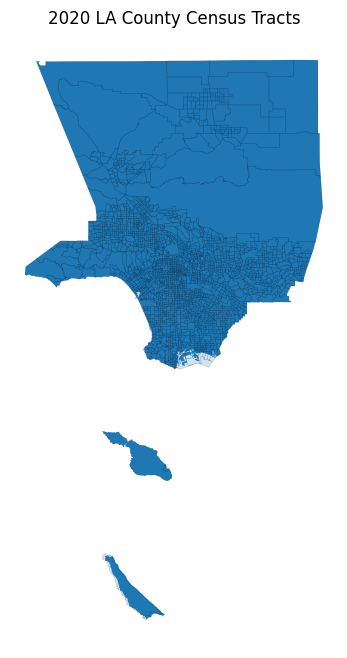

In [ ]:
# plot tracts layered over county
fig, ax = plt.subplots(figsize = (10, 8))
county_bound.plot(ax = ax)
svi.plot(ax = ax, alpha = 0.2, edgecolor = 'black', linewidth = 0.3)
ax.set(title = '2020 LA County Census Tracts')
ax.set_axis_off()
plt.savefig('fig1', bbox_inches = 'tight', dpi = 600)

##



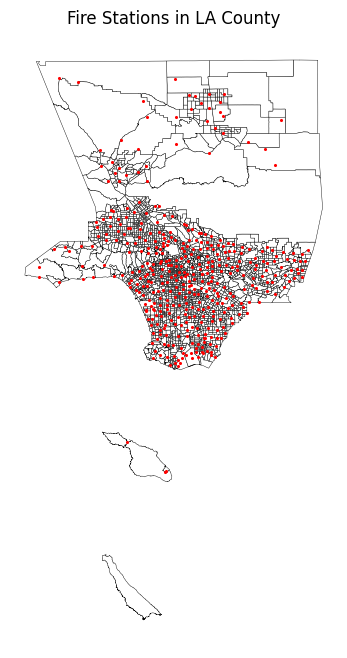

In [ ]:
# plot station locations on top of census tracts
fig, ax = plt.subplots(figsize=(10, 8))

svi.plot(ax = ax, color = 'white', edgecolor = 'black', linewidth = 0.3)
all_stations.plot(ax = ax, marker = 'o', color = 'red', markersize = 1.5)
ax.set(title = 'Fire Stations in LA County')
ax.set_axis_off()
plt.savefig('fig2', bbox_inches = 'tight', dpi = 600)

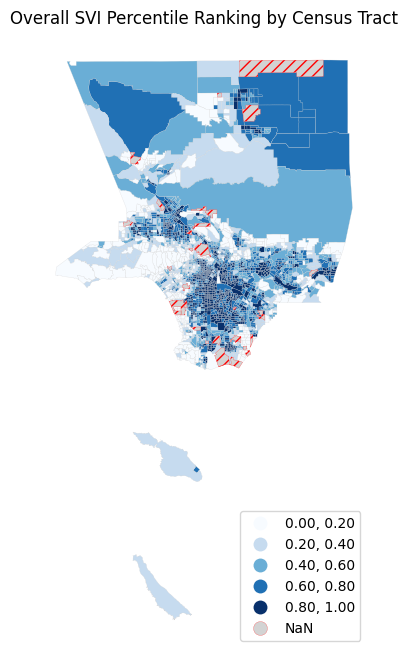

In [ ]:
# plot overall SVI percentile ranking by census tract
fig, ax = plt.subplots(figsize = (10, 8))
svi.plot(
    ax=ax,
    column='rpl_themes',
    scheme = 'prettybreaks',
    legend = True,
    cmap = 'Blues',
    linewidth = 0.15,
    edgecolor = 'lightgray',
    legend_kwds = {
        'loc': 'lower right',
        'frameon': 'True'
    },
    missing_kwds = {
        'color': "lightgrey",
        'edgecolor': "red",
        'hatch': '///',
        'label': 'NaN',
    }
)
ax.set(title = 'Overall SVI Percentile Ranking by Census Tract')
ax.set_axis_off()
plt.savefig('fig3', bbox_inches = 'tight', dpi = 600)

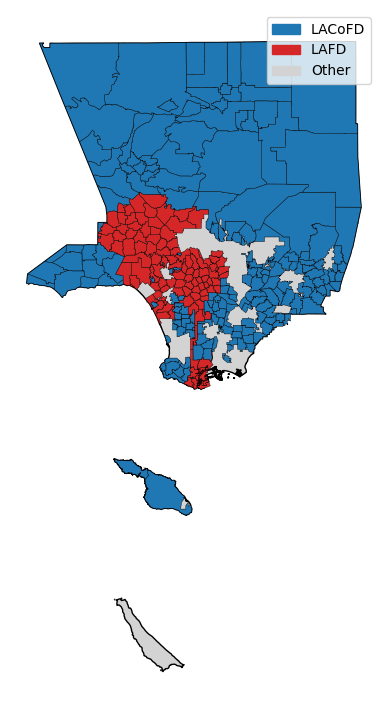

In [ ]:
# Station boundaries
fig, ax = plt.subplots(figsize = (11, 9))
county_bound.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
lacofd_bounds.plot(
    ax = ax,
    edgecolor = 'black',
    linewidth = 0.3
)
lafd_bounds.plot(
    ax = ax,
    color = 'C3',
    edgecolor = 'black',
    linewidth = 0.3
)
ax.set_axis_off()
blue_patch = mpatches.Patch(color = 'C0', label = 'LACoFD')
red_patch = mpatches.Patch(color = 'C3', label = 'LAFD')
gray_patch = mpatches.Patch(color = 'lightgray', label = 'Other')
ax.legend(handles = [blue_patch, red_patch, gray_patch])
plt.savefig('fig4', bbox_inches = 'tight', dpi = 600)



---



In [ ]:
# need to verify this (specifically LACoFD stations)
all_stations['department'].value_counts()

,count
department,
LACoFD,163
LAFD,106
Long Beach Fire Department,24
Glendale Fire Department,9
Pasadena Fire Department,8
Burbank Fire Department,6
Torrance Fire Department,6
West Covina Fire Department,5
United States Forest Service Angeles National Forest,5
